<a href="https://colab.research.google.com/github/shikhargoswami/Book_Recommender/blob/master/book_recommender.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup and Data Loading

In [95]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import os
from google.colab import drive

In [96]:
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [97]:
os.chdir('/gdrive/My Drive/Book Recommender')
root = os.getcwd()

In [98]:
data_path = os.path.join(root, 'dataset')

In [99]:
os.listdir(data_path)

['book_tags.csv',
 'books.csv',
 'ratings.csv',
 'sample_book.xml',
 'to_read.csv',
 'tags.csv']

In [100]:
ratings = pd.read_csv(data_path+'/ratings.csv')
books = pd.read_csv(data_path+'/books.csv')
book_tags = pd.read_csv(data_path+'/book_tags.csv')
tags = pd.read_csv(data_path+'/tags.csv')

In [101]:
ratings.head()

,book_id,user_id,rating
0,1,314,5
1,1,439,3
2,1,588,5
3,1,1169,4
4,1,1185,4


In [102]:
books.head()

,id,book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,title,language_code,average_rating,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
0,1,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,"The Hunger Games (The Hunger Games, #1)",eng,4.34,4780653,4942365,155254,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...
1,2,3,3,4640799,491,439554934,9.780440e+12,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,Harry Potter and the Sorcerer's Stone (Harry P...,eng,4.44,4602479,4800065,75867,75504,101676,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...
2,3,41865,41865,3212258,226,316015849,9.780316e+12,Stephenie Meyer,2005.0,Twilight,"Twilight (Twilight, #1)",en-US,3.57,3866839,3916824,95009,456191,436802,793319,875073,1355439,https://images.gr-assets.com/books/1361039443m...,https://images.gr-assets.com/books/1361039443s...
3,4,2657,2657,3275794,487,61120081,9.780061e+12,Harper Lee,1960.0,To Kill a Mockingbird,To Kill a Mockingbird,eng,4.25,3198671,3340896,72586,60427,117415,446835,1001952,1714267,https://images.gr-assets.com/books/1361975680m...,https://images.gr-assets.com/books/1361975680s...
4,5,4671,4671,245494,1356,743273567,9.780743e+12,F. Scott Fitzgerald,1925.0,The Great Gatsby,The Great Gatsby,eng,3.89,2683664,2773745,51992,86236,197621,606158,936012,947718,https://images.gr-assets.com/books/1490528560m...,https://images.gr-assets.com/books/1490528560s...


In [103]:
book_tags.head()

,goodreads_book_id,tag_id,count
0,1,30574,167697
1,1,11305,37174
2,1,11557,34173
3,1,8717,12986
4,1,33114,12716


In [104]:
tags.head()

,tag_id,tag_name
0,0,-
1,1,--1-
2,2,--10-
3,3,--12-
4,4,--122-


# Data Exploration

**Missing values**

In [105]:
ratings.isna().sum()

book_id    0
user_id    0
rating     0
dtype: int64

In [106]:
books.isna().sum()

id                              0
book_id                         0
best_book_id                    0
work_id                         0
books_count                     0
isbn                          700
isbn13                        585
authors                         0
original_publication_year      21
original_title                585
title                           0
language_code                1084
average_rating                  0
ratings_count                   0
work_ratings_count              0
work_text_reviews_count         0
ratings_1                       0
ratings_2                       0
ratings_3                       0
ratings_4                       0
ratings_5                       0
image_url                       0
small_image_url                 0
dtype: int64

In [107]:
book_tags.isna().sum()

goodreads_book_id    0
tag_id               0
count                0
dtype: int64

In [108]:
tags.isna().sum()

tag_id      0
tag_name    0
dtype: int64

**Conclusion:** Data is clean, missing values are only in the columns that are not important

In [109]:
# range of ratings
print("Min rating:{}\nMax rating:{}".format(ratings['rating'].min(), ratings['rating'].max()))

Min rating:1
Max rating:5


**Checking if there are multiple ratings given by same user on same book**

In [110]:
count = 0
ratings_clean = ratings.drop_duplicates(["book_id", "user_id"])

In [111]:
print("No. of duplicate ratings: {}".format(ratings.shape[0]- ratings_clean.shape[0]))

No. of duplicate ratings: 2278


In [112]:
ratings = ratings_clean

**Checking the most frequent rating users give**

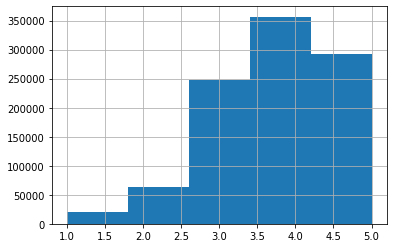

In [113]:
ratings['rating'].hist(bins=5)

Most users have given rating 4

In [114]:
# Dropping duplicates rows
books = books.drop_duplicates()
book_tags = book_tags.drop_duplicates()
tags= tags.drop_duplicates()

In [115]:
print("Total number of ratings all the users have given:{}".format(ratings.shape[0]))
print("Total number of unique users:{}".format(ratings['user_id'].nunique()))
print("Total number of books:{}".format(books.shape[0]))

Total number of ratings all the users have given:979478
Total number of unique users:53424
Total number of books:10000


# Approach

**There are 3 wasy an engine can recommend books to user:**
1. **Popularity Model**: Suggesting most popular books that other users have given, based on the ratings count of the book.It is    not personalised to the user as it only takes into account what other users have read/reviewed.


2. **Content Based Model**: It suggests books based on the reading history of a user. It is limited in recommendation as it will    suggest only books similar to what the user has previously read-> same genre, same authors etc.


3. **Collaborative Model**: It takes into account the preferences of both the user and similar users. If user A has bought a        book, and user B has also bought the same book, then for A, it is best to recommend a book which B has bought and A hasn't      read it.

**I'll use collaborative filtering**

## Model

In [116]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

**Creating embeddings that represent semantic relationship b/w users and books**

In [117]:
n_users = ratings['user_id'].nunique()
n_books = ratings['book_id'].nunique()

In [118]:
X = ratings[['user_id', 'book_id']].values
y = ratings.rating.values

**Splitting into train and test data**

In [119]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
print(X_train.shape, y_test.shape)

(783582, 2) (195896,)


In [120]:
X_train = [X_train[:, 0], X_train[:, 1]]
X_test = [X_test[:, 0], X_test[:, 1]]

**User embedding will represent user's personal taste, book embedding will represent book's characteristics**

In [121]:
from keras.layers import Input, Embedding, Flatten, Dot, Dense, Dropout, Lambda, Concatenate
from keras.models import Model, Sequential

In [122]:
emb_dim = 10

def recommender(num_users, num_books, emb_dim, min_rating, max_rating):
  user = Input(shape=(1,))
  user_emb = Embedding(num_users+1, emb_dim)
  user_vec = Flatten()(user_emb(user))

  book = Input(shape=(1,))
  book_emb = Embedding(num_books+1, emb_dim)
  book_vec = Flatten()(book_emb(book))

  merge = Concatenate()([book_vec, user_vec])

  x = Dense(16, kernel_initializer='he_normal', activation='relu')(merge)
  x = Dropout(0.5)(x)
  out = Dense(1, kernel_initializer='he_normal', activation='sigmoid')(x)
  out = Lambda(lambda x: x * (max_rating - min_rating) + min_rating)(out)

  model = Model([user, book], out)
  model.compile(optimizer='adam', loss='mse') 

  return model

In [123]:
model = recommender(n_users, n_books, emb_dim, ratings.rating.min(), ratings.rating.max())
model.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, 1, 10)        100010      input_6[0][0]                    
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 1, 10)        534250      input_5[0][0]                    
_______________________________________________________________________________________

In [124]:
%%time
history = model.fit(x=X_train, y=y_train, batch_size=64, epochs=10, verbose=1, validation_data=(X_test, y_test))

Epoch 1/10
12244/12244 [==============================] - 108s 9ms/step - loss: 0.8174 - val_loss: 0.7200
Epoch 2/10
12244/12244 [==============================] - 112s 9ms/step - loss: 0.7110 - val_loss: 0.7041
Epoch 3/10
12244/12244 [==============================] - 109s 9ms/step - loss: 0.6858 - val_loss: 0.7005
Epoch 4/10
12244/12244 [==============================] - 108s 9ms/step - loss: 0.6710 - val_loss: 0.6998
Epoch 5/10
12244/12244 [==============================] - 109s 9ms/step - loss: 0.6605 - val_loss: 0.7008
Epoch 6/10
12244/12244 [==============================] - 107s 9ms/step - loss: 0.6533 - val_loss: 0.7036
Epoch 7/10
12244/12244 [==============================] - 106s 9ms/step - loss: 0.6478 - val_loss: 0.7045
Epoch 8/10
12244/12244 [==============================] - 108s 9ms/step - loss: 0.6426 - val_loss: 0.7051
Epoch 9/10
12244/12244 [==============================] - 101s 8ms/step - loss: 0.6383 - val_loss: 0.7074
Epoch 10/10
12244/12244 [=====================

In [125]:
model.metrics_names

['loss']

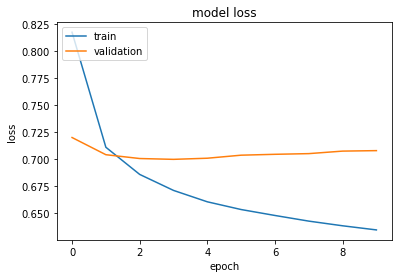

In [126]:

# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

I have only trained for 10 epochs as time constraint was there. Also, we could train on gpu runtime.
I tried different hyperparameters emb_dims, initializatioin_methods. This has given min loss for these epochs

In [127]:
model.save('recommender_model.h5')

In [128]:
user_emb =model.get_layer(index=2)
book_emb = model.get_layer(index=3)

# Book recommendation

In [171]:
def recommend_books_for(user):
  emb_user = user_emb.get_weights()[0]
  emb_book = book_emb.get_weights()[0]
  
  
  books_ranked_for_user = (np.dot(emb_book, emb_user[user]))

  top_book_ids = np.argsort(books_ranked_for_user)[-5:]
  df = books[books.book_id.isin(top_book_ids)][['title', 'authors','average_rating']]
  return df

In [172]:
this_user = 4562

In [175]:
print("User {} has read:".format(this_user))
r = ratings[ratings['user_id']==4562].book_id
books[books['book_id'].isin(r)][['title', 'authors', 'average_rating']]

User 4562 has read:


,title,authors,average_rating
484,The Brothers Karamazov,"Fyodor Dostoyevsky, Richard Pevear, Larissa Vo...",4.30
2736,"The Big Bad Wolf (Alex Cross, #9)",James Patterson,3.97


In [176]:
print("Top recommendations for user {}".format(this_user))
top_books = recommend_books_for(this_user)
top_books

Top recommendations for user 4562


,title,authors,average_rating
1366,The Once and Future King (The Once and Future ...,T.H. White,4.08
